### Multivariate Time Series Forecasting by application of PatchTST (Transformer) on ETTh1 Dataset
-Lookback window = 336

-Forecast window = 96

In [31]:
import torch
from torch.utils.data import Dataset

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# !pip install wandb
import wandb
import random
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
print(torch.__version__)

2.0.1+cu118


In [32]:

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="transformer_timeseries",
)


In [33]:
'''
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/')


df=pd.read_csv('WTH.csv')
# df.drop('Unnamed: 0',axis=1,inplace=True)
df
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nimport os\nos.chdir('/content/drive/My Drive/')\n\n\ndf=pd.read_csv('WTH.csv')\n# df.drop('Unnamed: 0',axis=1,inplace=True)\ndf\n"

In [34]:
df=pd.read_csv('ETTh1.csv',index_col=None)
# df.drop('Unnamed: 0',axis=1,inplace=True)
df.iloc[:,1:]

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...
17415,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [35]:
scaler = StandardScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])
df

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,-0.219049,-0.114207,-0.395683,-0.231903,0.976355,0.805738,2.008513
1,2016-07-01 01:00:00,-0.238009,-0.081400,-0.411356,-0.251800,0.923970,0.857445,1.688203
2,2016-07-01 02:00:00,-0.313849,-0.245432,-0.442557,-0.291043,0.610524,0.602247,1.688203
3,2016-07-01 03:00:00,-0.323329,-0.147013,-0.442557,-0.271146,0.636286,0.703993,1.368010
4,2016-07-01 04:00:00,-0.285409,-0.147013,-0.411356,-0.231903,0.688671,0.703993,1.006610
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.280380,0.640341,-1.452403,0.691136,0.348602,1.110975,-0.282568
17416,2018-06-26 16:00:00,-1.820597,1.001211,-1.967580,0.769622,0.400987,1.364505,-0.266225
17417,2018-06-26 17:00:00,-0.645506,0.771566,-0.749583,0.671791,0.558139,1.110975,-0.356458
17418,2018-06-26 18:00:00,0.264287,0.771566,0.171642,0.671791,0.505755,0.959190,-0.414007


In [36]:
class weather_data(torch.utils.data.Dataset):
    def __init__(self, df, mode="train", seq_len=336, pred_len=96,num_feat=7):
        super().__init__()
        self.num_feat=num_feat
        self.df = df.iloc[:,1:num_feat+1]
        # time_stamp = df.iloc[:,0]

        assert mode in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[mode]

        self.seq_len = seq_len
        self.pred_len = pred_len
        dataset_len=len(df)

        border1s = [0, int(round(0.7*dataset_len,0)) - self.seq_len, int(round(0.7*dataset_len,0)) + int(round(0.1*dataset_len,0)) - self.seq_len]
        border2s = [int(round(0.7*dataset_len,0)), int(round(0.7*dataset_len,0)) + int(round(0.1*dataset_len,0)), int(round(0.7*dataset_len,0)) + int(round(0.1*dataset_len,0)) + int(round(0.2*dataset_len,0))]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]




        self.df = self.df.to_numpy(dtype=np.float32)
        # time_stamp = time_stamp.to_numpy()

        self.data_x = self.df[border1: border2, :]
        self.data_y = self.df[border1: border2, :]

        # self.data_stamp = time_stamp[border1: border2]

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        return seq_x, seq_y


    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

In [37]:
from torch.utils.data import DataLoader

train_dataset = weather_data(df=df)
valid_dataset = weather_data(df=df,mode="val")
test_dataset = weather_data(df=df,mode="test")

print(len(train_dataset),len(valid_dataset),len(test_dataset))

11763 1647 3389


In [38]:
train_dataset[1][1].shape

(96, 7)

In [39]:
import os
current_directory = os.getcwd()
os.chdir(current_directory+r"\PatchTST\PatchTST_supervised")
from PatchTST.PatchTST_supervised.models.PatchTST import Model
os.chdir(current_directory)
Model

PatchTST.PatchTST_supervised.models.PatchTST.Model

In [40]:
class Configs:
    def __init__(self):
        self.enc_in = 7
        self.seq_len = 336
        self.pred_len = 96
        self.e_layers = 3
        self.n_heads = 8
        self.d_model = 128
        self.d_ff = 512
        self.dropout = 0.4
        self.fc_dropout = 0.
        self.head_dropout = 0.
        self.individual = True
        self.patch_len = 24
        self.stride = 8
        self.padding_patch = True
        self.revin = True
        self.affine = False
        self.subtract_last = False
        self.decomposition = False
        self.kernel_size = 25
        
my_configs = Configs()
model=Model(configs=my_configs)

In [41]:
'''
class Configs:
    def __init__(self):
        self.enc_in = 7
        self.seq_len = 336
        self.pred_len = 96
        self.e_layers = 3
        self.n_heads = 8
        self.d_model = 32
        self.d_ff = 128*2*2
        self.dropout = 0.3
        self.fc_dropout = 0.
        self.head_dropout = 0.
        self.individual = True
        self.patch_len = 24
        self.stride = 2
        self.padding_patch = True
        self.revin = True
        self.affine = False
        self.subtract_last = False
        self.decomposition = False
        self.kernel_size = 25
        
my_configs = Configs()
model=Model(configs=my_configs)
'''

'\nclass Configs:\n    def __init__(self):\n        self.enc_in = 7\n        self.seq_len = 336\n        self.pred_len = 96\n        self.e_layers = 3\n        self.n_heads = 8\n        self.d_model = 32\n        self.d_ff = 128*2*2\n        self.dropout = 0.3\n        self.fc_dropout = 0.\n        self.head_dropout = 0.\n        self.individual = True\n        self.patch_len = 24\n        self.stride = 2\n        self.padding_patch = True\n        self.revin = True\n        self.affine = False\n        self.subtract_last = False\n        self.decomposition = False\n        self.kernel_size = 25\n        \nmy_configs = Configs()\nmodel=Model(configs=my_configs)\n'

In [42]:
dat=torch.from_numpy(train_dataset[0][0])
dat=dat.unsqueeze(dim=0)
dat.shape
model(dat).shape

torch.Size([1, 96, 7])

In [43]:
import gc
torch.cuda.empty_cache()
gc.collect()

18208

In [44]:
class model_run:
    def __init__(self,model=model):
        self.patchtst_model = model
        
    def model_architecture(self):
        n=0
        for x in self.patchtst_model.state_dict():
            n=n+1
            print(x)
        print("layers= ",n)

    def load_datasets(self,train_dataset=train_dataset,valid_dataset=valid_dataset,test_dataset=test_dataset):
        self.train_dataset=train_dataset
        self.valid_dataset=valid_dataset
        self.test_dataset=test_dataset



    def model_hyperparameters(self,batch_size=128,lr=0.00001,epochs=150,cuda=True,Dataloader=DataLoader):
        self.batch_size = batch_size
        self.lr=lr
        self.epochs=epochs

        self.train_dataloader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=1, shuffle=False)
        self.valid_dataloader = DataLoader(self.valid_dataset, batch_size=batch_size, shuffle=True)


        if cuda:
            self.patchtst_model=self.patchtst_model.to("cuda")

        self.optimizer = torch.optim.Adam(self.patchtst_model.parameters(), lr=self.lr)
        self.loss = torch.nn.MSELoss()
        self.loss_mae=torch.nn.L1Loss()

    def model_execute(self,):
        self.load_datasets()
        self.model_hyperparameters()

        for epoch in range(self.epochs):
            iter_count = 0
            total_loss = 0
            train_steps=0
            total_train_mae_loss=0

            for train_x, train_y in tqdm(self.train_dataloader):
                train_x = train_x.to("cuda")
                train_y = train_y.to("cuda")
                
                self.i=train_x
                pred_y = self.patchtst_model(train_x)
                # print(train_x.shape)
                # print(train_y.shape)
                # print(pred_y.shape)
                train_mae_loss=self.loss_mae(pred_y, train_y)

                loss_t = self.loss(pred_y, train_y)
                self.optimizer.zero_grad()
                loss_t.backward()
                self.optimizer.step()
                total_loss += loss_t.item()
                total_train_mae_loss += train_mae_loss.item()
                iter_count += 1
                train_steps += 1

            valid_iter_count = 0
            valid_total_loss = 0
            valid_total_mae = 0
            with torch.no_grad():
                for valid_x, valid_y in self.valid_dataloader:
                    valid_x = valid_x.to("cuda")
                    valid_y = valid_y.to("cuda")
                    pred_y = self.patchtst_model(valid_x)
                    loss_v = self.loss(pred_y, valid_y)
                    valid_loss_mae=self.loss_mae(pred_y, valid_y)

                    valid_total_loss += loss_v.item()
                    valid_iter_count += 1

                    valid_total_mae+=valid_loss_mae.item()

                total_loss /= iter_count
                total_train_mae_loss /= iter_count

                valid_total_loss /= valid_iter_count
                valid_total_mae /= valid_iter_count
                wandb.log({"MSE Train": total_loss, "MSE Test": valid_total_loss,"MAE Train": total_train_mae_loss,"MAE Test": valid_total_mae})

                print("epoch: {} MSE loss: {:.4f} MSE valid loss: {:.4f}".format(epoch, total_loss, valid_total_loss))
                print("          MAE loss: {:.4f} MAE valid loss: {:.4f}".format(total_train_mae_loss, valid_total_mae))

    def save_model(self,name):
        torch.save(self.patchtst_model.state_dict(), name+'.pth')


    def test_plots(self,ind=3,df_columns=None,scaler=None,column=None):
        test_total_loss = 0
        test_total_loss_mae=0
        test_iter_count = 0
        test_pred_plot=[]
        test_y_plot=[]
        
        df_y_final=pd.DataFrame(columns=df_columns)
        df_pred_final=pd.DataFrame(columns=df_columns)
        
        for test_x, test_y in self.test_dataloader:
            test_x = test_x.to("cuda")
            test_y = test_y.to("cuda")
            test_pred=self.patchtst_model(test_x.to("cuda"))
            # print(test_pred.shape)
            # print(test_y.shape)
            loss_test=self.loss(test_pred, test_y)
            test_total_loss += loss_test.item()
            
            loss_test_mae=self.loss_mae(test_pred, test_y)
            test_total_loss_mae+=loss_test_mae.item()
            
            test_iter_count += 1
            
            
            df_y=pd.DataFrame(test_y[0].to("cpu").numpy(),columns=df_columns)
            df_pred=pd.DataFrame(test_pred[0].to("cpu").detach().numpy(),columns=df_columns)
            
            df_y_final = pd.concat([df_y_final, df_y], axis=0)
            df_pred_final = pd.concat([df_pred_final, df_pred], axis=0)
        df_pred_final=scaler.inverse_transform(df_pred_final)   
        df_y_final=scaler.inverse_transform(df_y_final)
        
        df_pred_final=pd.DataFrame(df_pred_final,columns=df_columns)
        df_y_final=pd.DataFrame(df_y_final,columns=df_columns)
        
        
        sns.lineplot(x=list(range(len(df_y_final)))[:96], y=df_y_final[column][:96], label="GroundTruth")
        sns.lineplot(x=list(range(len(df_pred_final)))[:96], y=df_pred_final[column][:96], label="Prediction")
        plt.legend(title='Type')
        plt.xlabel('Time Step')
        plt.title("Predicted vs Actual")
        plt.show()
        
        
        test_total_loss/= test_iter_count
        test_total_loss_mae/=test_iter_count
        print("MSE test loss: ",test_total_loss)
        print("MAE test loss: ",test_total_loss_mae)
         
'''
            # plotting
            
            for i,j in zip(test_pred[0],test_y[0]):
                pass
            # print(i[ind].item())
                test_pred_plot.append(i[ind].item())
            # print(j[ind].item())
                test_y_plot.append(j[ind].item())
        sns.lineplot(x=list(range(len(test_pred_plot)))[:96], y=test_pred_plot[:96], label="predicted")
        sns.lineplot(x=list(range(len(test_y_plot)))[:96], y=test_y_plot[:96], label="actual")
        plt.legend(title='Lines')
        plt.show()
        test_total_loss/= test_iter_count
        print("MSE test loss: ",test_total_loss)

        '''


'\n            # plotting\n            \n            for i,j in zip(test_pred[0],test_y[0]):\n                pass\n            # print(i[ind].item())\n                test_pred_plot.append(i[ind].item())\n            # print(j[ind].item())\n                test_y_plot.append(j[ind].item())\n        sns.lineplot(x=list(range(len(test_pred_plot)))[:96], y=test_pred_plot[:96], label="predicted")\n        sns.lineplot(x=list(range(len(test_y_plot)))[:96], y=test_y_plot[:96], label="actual")\n        plt.legend(title=\'Lines\')\n        plt.show()\n        test_total_loss/= test_iter_count\n        print("MSE test loss: ",test_total_loss)\n\n        '

In [45]:
x=model_run(model=model)

In [46]:
x.model_execute()

100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.84it/s]


epoch: 0 MSE loss: 0.6558 MSE valid loss: 0.4681
          MAE loss: 0.5796 MAE valid loss: 0.4971


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  9.09it/s]


epoch: 1 MSE loss: 0.5286 MSE valid loss: 0.4307
          MAE loss: 0.5191 MAE valid loss: 0.4727


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  9.06it/s]


epoch: 2 MSE loss: 0.4886 MSE valid loss: 0.4134
          MAE loss: 0.4979 MAE valid loss: 0.4610


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  9.03it/s]


epoch: 3 MSE loss: 0.4651 MSE valid loss: 0.4002
          MAE loss: 0.4843 MAE valid loss: 0.4518


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  9.02it/s]


epoch: 4 MSE loss: 0.4481 MSE valid loss: 0.3912
          MAE loss: 0.4744 MAE valid loss: 0.4456


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  9.02it/s]


epoch: 5 MSE loss: 0.4349 MSE valid loss: 0.3836
          MAE loss: 0.4664 MAE valid loss: 0.4396


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.99it/s]


epoch: 6 MSE loss: 0.4250 MSE valid loss: 0.3780
          MAE loss: 0.4600 MAE valid loss: 0.4354


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.97it/s]


epoch: 7 MSE loss: 0.4170 MSE valid loss: 0.3723
          MAE loss: 0.4551 MAE valid loss: 0.4310


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.96it/s]


epoch: 8 MSE loss: 0.4105 MSE valid loss: 0.3695
          MAE loss: 0.4509 MAE valid loss: 0.4287


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.94it/s]


epoch: 9 MSE loss: 0.4053 MSE valid loss: 0.3670
          MAE loss: 0.4480 MAE valid loss: 0.4262


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.93it/s]


epoch: 10 MSE loss: 0.4006 MSE valid loss: 0.3642
          MAE loss: 0.4448 MAE valid loss: 0.4242


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.94it/s]


epoch: 11 MSE loss: 0.3969 MSE valid loss: 0.3619
          MAE loss: 0.4426 MAE valid loss: 0.4223


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.94it/s]


epoch: 12 MSE loss: 0.3938 MSE valid loss: 0.3599
          MAE loss: 0.4407 MAE valid loss: 0.4205


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.94it/s]


epoch: 13 MSE loss: 0.3912 MSE valid loss: 0.3597
          MAE loss: 0.4393 MAE valid loss: 0.4199


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.95it/s]


epoch: 14 MSE loss: 0.3891 MSE valid loss: 0.3571
          MAE loss: 0.4377 MAE valid loss: 0.4180


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.93it/s]


epoch: 15 MSE loss: 0.3866 MSE valid loss: 0.3566
          MAE loss: 0.4363 MAE valid loss: 0.4175


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.95it/s]


epoch: 16 MSE loss: 0.3848 MSE valid loss: 0.3553
          MAE loss: 0.4351 MAE valid loss: 0.4164


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.93it/s]


epoch: 17 MSE loss: 0.3830 MSE valid loss: 0.3542
          MAE loss: 0.4341 MAE valid loss: 0.4154


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.93it/s]


epoch: 18 MSE loss: 0.3814 MSE valid loss: 0.3534
          MAE loss: 0.4333 MAE valid loss: 0.4146


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.91it/s]


epoch: 19 MSE loss: 0.3798 MSE valid loss: 0.3529
          MAE loss: 0.4321 MAE valid loss: 0.4142


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.90it/s]


epoch: 20 MSE loss: 0.3782 MSE valid loss: 0.3511
          MAE loss: 0.4316 MAE valid loss: 0.4129


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.90it/s]


epoch: 21 MSE loss: 0.3766 MSE valid loss: 0.3519
          MAE loss: 0.4304 MAE valid loss: 0.4128


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.91it/s]


epoch: 22 MSE loss: 0.3755 MSE valid loss: 0.3505
          MAE loss: 0.4298 MAE valid loss: 0.4121


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.91it/s]


epoch: 23 MSE loss: 0.3741 MSE valid loss: 0.3505
          MAE loss: 0.4290 MAE valid loss: 0.4120


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.91it/s]


epoch: 24 MSE loss: 0.3732 MSE valid loss: 0.3502
          MAE loss: 0.4286 MAE valid loss: 0.4116


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.92it/s]


epoch: 25 MSE loss: 0.3718 MSE valid loss: 0.3491
          MAE loss: 0.4278 MAE valid loss: 0.4108


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.92it/s]


epoch: 26 MSE loss: 0.3708 MSE valid loss: 0.3484
          MAE loss: 0.4271 MAE valid loss: 0.4102


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.92it/s]


epoch: 27 MSE loss: 0.3700 MSE valid loss: 0.3479
          MAE loss: 0.4267 MAE valid loss: 0.4096


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.90it/s]


epoch: 28 MSE loss: 0.3690 MSE valid loss: 0.3480
          MAE loss: 0.4260 MAE valid loss: 0.4097


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.89it/s]


epoch: 29 MSE loss: 0.3677 MSE valid loss: 0.3479
          MAE loss: 0.4256 MAE valid loss: 0.4096


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.88it/s]


epoch: 30 MSE loss: 0.3670 MSE valid loss: 0.3469
          MAE loss: 0.4249 MAE valid loss: 0.4088


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.89it/s]


epoch: 31 MSE loss: 0.3656 MSE valid loss: 0.3460
          MAE loss: 0.4244 MAE valid loss: 0.4083


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.89it/s]


epoch: 32 MSE loss: 0.3647 MSE valid loss: 0.3468
          MAE loss: 0.4236 MAE valid loss: 0.4084


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.90it/s]


epoch: 33 MSE loss: 0.3641 MSE valid loss: 0.3463
          MAE loss: 0.4236 MAE valid loss: 0.4081


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.90it/s]


epoch: 34 MSE loss: 0.3627 MSE valid loss: 0.3463
          MAE loss: 0.4227 MAE valid loss: 0.4080


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.89it/s]


epoch: 35 MSE loss: 0.3619 MSE valid loss: 0.3464
          MAE loss: 0.4222 MAE valid loss: 0.4078


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.91it/s]


epoch: 36 MSE loss: 0.3612 MSE valid loss: 0.3450
          MAE loss: 0.4219 MAE valid loss: 0.4071


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.91it/s]


epoch: 37 MSE loss: 0.3607 MSE valid loss: 0.3453
          MAE loss: 0.4215 MAE valid loss: 0.4074


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.91it/s]


epoch: 38 MSE loss: 0.3595 MSE valid loss: 0.3446
          MAE loss: 0.4208 MAE valid loss: 0.4067


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.89it/s]


epoch: 39 MSE loss: 0.3589 MSE valid loss: 0.3436
          MAE loss: 0.4206 MAE valid loss: 0.4061


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.89it/s]


epoch: 40 MSE loss: 0.3581 MSE valid loss: 0.3440
          MAE loss: 0.4199 MAE valid loss: 0.4062


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.88it/s]


epoch: 41 MSE loss: 0.3572 MSE valid loss: 0.3435
          MAE loss: 0.4198 MAE valid loss: 0.4058


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.88it/s]


epoch: 42 MSE loss: 0.3565 MSE valid loss: 0.3441
          MAE loss: 0.4191 MAE valid loss: 0.4061


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.84it/s]


epoch: 43 MSE loss: 0.3557 MSE valid loss: 0.3439
          MAE loss: 0.4189 MAE valid loss: 0.4059


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.87it/s]


epoch: 44 MSE loss: 0.3548 MSE valid loss: 0.3430
          MAE loss: 0.4180 MAE valid loss: 0.4054


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.90it/s]


epoch: 45 MSE loss: 0.3540 MSE valid loss: 0.3428
          MAE loss: 0.4179 MAE valid loss: 0.4052


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.90it/s]


epoch: 46 MSE loss: 0.3531 MSE valid loss: 0.3421
          MAE loss: 0.4172 MAE valid loss: 0.4049


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.92it/s]


epoch: 47 MSE loss: 0.3527 MSE valid loss: 0.3421
          MAE loss: 0.4171 MAE valid loss: 0.4046


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.91it/s]


epoch: 48 MSE loss: 0.3520 MSE valid loss: 0.3421
          MAE loss: 0.4166 MAE valid loss: 0.4045


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.92it/s]


epoch: 49 MSE loss: 0.3511 MSE valid loss: 0.3424
          MAE loss: 0.4163 MAE valid loss: 0.4048


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.90it/s]


epoch: 50 MSE loss: 0.3503 MSE valid loss: 0.3424
          MAE loss: 0.4159 MAE valid loss: 0.4046


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.91it/s]


epoch: 51 MSE loss: 0.3494 MSE valid loss: 0.3417
          MAE loss: 0.4155 MAE valid loss: 0.4041


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.90it/s]


epoch: 52 MSE loss: 0.3493 MSE valid loss: 0.3414
          MAE loss: 0.4151 MAE valid loss: 0.4040


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.91it/s]


epoch: 53 MSE loss: 0.3484 MSE valid loss: 0.3408
          MAE loss: 0.4147 MAE valid loss: 0.4035


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:10<00:00,  8.91it/s]


epoch: 54 MSE loss: 0.3475 MSE valid loss: 0.3398
          MAE loss: 0.4144 MAE valid loss: 0.4030


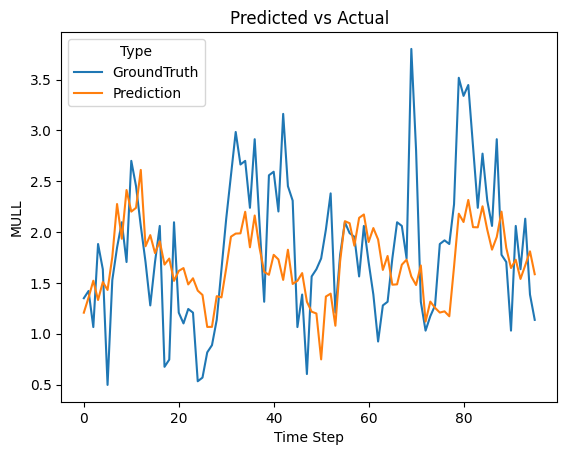

MSE test loss:  0.43017596567000704
MAE test loss:  0.4711081096734857


In [47]:
x.test_plots(df_columns=df.columns[1:],scaler=scaler,column='MULL')

In [48]:
'''
dat=torch.from_numpy(train_dataset[0][0])
dat=dat.unsqueeze(dim=0)
dat.shape
model(dat).shape
'''

'\ndat=torch.from_numpy(train_dataset[0][0])\ndat=dat.unsqueeze(dim=0)\ndat.shape\nmodel(dat).shape\n'